## Imports

In [1]:
import pandas as pd
import numpy as np 
import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import AUC,Precision,Recall,TruePositives,TrueNegatives,FalsePositives,FalseNegatives
from tensorflow.keras.optimizers import RMSprop
import tensorflow_hub as tfhub
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import pydicom
import cv2

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reading train labels and sample submission csv

In [2]:
# Reading the training label and sample submission

train_labels=pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
sample_submission= pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

In [3]:
train_labels.head(10)

BraTS21ID  MGMT_value
0          0           1
1          2           1
2          3           0
3          5           1
4          6           1
5          8           1
6          9           0
7         11           1
8         12           1
9         14           1

In [4]:
sample_submission.head(10)

BraTS21ID  MGMT_value
0          1         0.5
1         13         0.5
2         15         0.5
3         27         0.5
4         37         0.5
5         47         0.5
6         79         0.5
7         80         0.5
8         82         0.5
9         91         0.5

## Transforming BraTS21ID in train labels

In [5]:
# Transform the ids in the training label to match the data 
def transform_ids(data):
    zeros = 5 - len(str(data))
    if zeros > 0:
        prefix = ''.join(['0' for i in range(zeros)])
    
    return prefix+str(data)
        
train_labels['BraTS21ID_full'] = train_labels['BraTS21ID'].apply(transform_ids)

## Adding path of MRI sequences in train labels csv

In [6]:
# Add the paths to the train labels for easy access

root_dir="../input/rsna-miccai-brain-tumor-radiogenomic-classification/"
train_labels['flair'] = train_labels['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/FLAIR/')
train_labels['t1w'] = train_labels['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/T1w/')
train_labels['t1wce'] = train_labels['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/T1wCE/')
train_labels['t2w'] = train_labels['BraTS21ID_full'].apply(lambda file_id : root_dir+'train/'+file_id+'/T2w/')

In [7]:
train_labels.head(12)

BraTS21ID  MGMT_value BraTS21ID_full  \
0           0           1          00000   
1           2           1          00002   
2           3           0          00003   
3           5           1          00005   
4           6           1          00006   
5           8           1          00008   
6           9           0          00009   
7          11           1          00011   
8          12           1          00012   
9          14           1          00014   
10         17           0          00017   
11         18           0          00018   

                                                flair  \
0   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
1   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
2   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
3   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
4   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
5   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
6   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
7   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
8   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
9   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
10  ../input/rsna-miccai-brain-tumor-radiogenomic-...   
11  ../input/rsna-miccai-brain-tumor-radiogenomic-...   

                                                  t1w  \
0   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
1   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
2   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
3   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
4   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
5   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
6   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
7   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
8   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
9   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
10  ../input/rsna-miccai-brain-tumor-radiogenomic-...   
11  ../input/rsna-miccai-brain-tumor-radiogenomic-...   

                                                t1wce  \
0   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
1   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
2   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
3   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
4   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
5   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
6   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
7   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
8   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
9   ../input/rsna-miccai-brain-tumor-radiogenomic-...   
10  ../input/rsna-miccai-brain-tumor-radiogenomic-...   
11  ../input/rsna-miccai-brain-tumor-radiogenomic-...   

                                                  t2w  
0   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
1   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
2   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
3   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
4   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
5   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
6   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
7   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
8   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
9   ../input/rsna-miccai-brain-tumor-radiogenomic-...  
10  ../input/rsna-miccai-brain-tumor-radiogenomic-...  
11  ../input/rsna-miccai-brain-tumor-radiogenomic-...

## Reading, transforming, adding path of MRI sequence in  Test Dataset

In [8]:
df_test = pd.read_csv(root_dir+'sample_submission.csv')

df_test['BraTS21ID_full'] = df_test['BraTS21ID'].apply(transform_ids)

# Add all the paths to the dataframe for easy access
df_test['flair'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/FLAIR/')
df_test['t1w'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/T1w/')
df_test['t1wce'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/T1wCE/')
df_test['t2w'] = df_test['BraTS21ID_full'].apply(lambda file_id : root_dir+'test/'+file_id+'/T2w/')

## Method to generate train and validation dataframe

### Below steps are performed in this method:-
   #### Filtering the defective, blank and not relevant BraTS21ID
   #### Performing stratified splitting based on BraTS21ID and ratio of 90%

In [9]:
def get_train_val_dataframe(mri_type):
    
    all_img_files = []
    all_img_labels = []
    all_img_patient_ids = []
    for row in train_labels.iterrows():
        if row[1]['BraTS21ID_full'] == '00109':
            continue
        if row[1]['BraTS21ID_full'] == '00123':
            continue
        if row[1]['BraTS21ID_full'] == '00709':
            continue
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.dcm', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.dcm' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+ele for ele in img_names]
        
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_img_files.extend(img_paths)
        all_img_labels.extend(img_labels)
        all_img_patient_ids.extend(img_patient_ids)

    train_val_df = pd.DataFrame({'patient_ids': all_img_patient_ids,
                  'labels': all_img_labels,
                  'file_paths': all_img_files})

    train_val_df['labels'] = train_val_df['labels'].map({1: '1', 0: '0'})
    
    #stratifiied 90% split on patient_ids and labels  
    class_prop= 0.90
    
    classes_splits  = {}
    for i in range(2):
        train_val_label_class = train_val_df[train_val_df['labels']==f'{i}']
        train_val_list_ids =  list(train_val_label_class['patient_ids'].unique())
        train_threshold = math.ceil(class_prop*len(train_val_list_ids))
        train_ids = train_val_list_ids[:train_threshold]
        val_ids = train_val_list_ids[train_threshold:]
        classes_splits[f'train_{i}'] = train_val_label_class[train_val_label_class['patient_ids'].isin(train_ids)]
        classes_splits[f'val_{i}'] = val_df = train_val_label_class[train_val_label_class['patient_ids'].isin(val_ids)]
        
    train_df = pd.concat([classes_splits['train_0'], classes_splits['train_1']], axis=0)
    val_df = pd.concat([classes_splits['val_0'], classes_splits['val_1']], axis=0)
  
    return train_df,val_df

## Method to generate test dataframe

### Below steps are performed in this method:-
   #### Filtering of blank and not relevant BraTS21ID

In [10]:
def get_test_dataframe(mri_type):
    
    all_test_img_files = []
    all_test_img_labels = []
    all_test_img_patient_ids = []
    for row in df_test.iterrows():
        img_dir = row[1][mri_type]
        img_files = os.listdir(img_dir)
        img_nums = sorted([int(ele.replace('Image-', '').replace('.dcm', '')) for ele in img_files])
        mid_point = int(len(img_nums)/2)
        start_point = mid_point - max(int(mid_point*0.1), 1)
        end_point = mid_point + max(int(mid_point*0.1), 1)
        img_names = [f'Image-{img_nums[i]}.dcm' for i in range(start_point, end_point+1)]
        img_paths = [img_dir+ele for ele in img_names]
        img_labels = [row[1]['MGMT_value']]*len(img_paths)
        img_patient_ids = [row[1]['BraTS21ID']]*len(img_paths)
        all_test_img_files.extend(img_paths)
        all_test_img_labels.extend(img_labels)
        all_test_img_patient_ids.extend(img_patient_ids)
    test_df = pd.DataFrame({'patient_ids': all_test_img_patient_ids,
                  'labels': all_test_img_labels,
                  'file_paths': all_test_img_files})
    test_df['labels'] = ['1']*(len(test_df)-1) + ['0'] # workaround for testing data gen
   
    return test_df

## Constants

In [11]:
SEED = 369
BATCH_SIZE = 128
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (299,299)

## Custom DataFrameIterator class

### Below steps are performed in this method: -

#### 1) Convert the dataset into transformed sample
#### 2) Convert the dicom image to pixel array

In [13]:
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])
        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(299, 299), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        pixels = image_array - np.min(image_array)
        pixels = pixels / np.max(pixels)
        image_manual_norm = (pixels * 255).astype(np.uint8)
        image_array = cv2.resize(image_manual_norm, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        if color_mode == 'rgb':
            image_array = np.dstack((image_array, np.zeros_like(image_array), np.zeros_like(image_array)))
        return image_array

## Method to generate data generator for train,validation,test
### Below steps are performed in this method:-
   #### 1) Train,validation,test data augementation parameters defined for real time data augmentation
   ####  2) Using DataFrameIterator, generators are created

In [12]:
def get_data_generators(train_df,val_df, test_df):
    
    train_augmentation_parameters = dict(
        rescale=1.0/255,
        zoom_range=0.2,
        rotation_range=0.2,
        fill_mode='nearest',
        height_shift_range= 0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        brightness_range = [0.8, 1.2]
    )
    
    val_augmentation_parameters = dict(
        rescale=1.0/255.0
        
    )

    test_augmentation_parameters = dict(
        rescale=1.0/255.0
    )

    train_consts = {
        'seed': SEED,
        'batch_size': BATCH_SIZE,
        'class_mode': CLASS_MODE,
        'color_mode': COLOR_MODE,
        'target_size': TARGET_SIZE,  
    }
    
    val_consts = {
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,
    'shuffle': False
    }

    test_consts = {
        'batch_size': BATCH_SIZE,
        'class_mode': CLASS_MODE,
        'color_mode': COLOR_MODE,
        'target_size': TARGET_SIZE,
        'shuffle': False
    }

    train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
    val_augmenter = ImageDataGenerator(**val_augmentation_parameters)
    test_augmenter = ImageDataGenerator(**test_augmentation_parameters)

    train_generator = DCMDataFrameIterator(dataframe=train_df,
                                 x_col='file_paths',
                                 y_col='labels',
                                 image_data_generator=train_augmenter,
                                 **train_consts)
    
    val_generator = DCMDataFrameIterator(dataframe=val_df,
                                 x_col='file_paths',
                                 y_col='labels',
                                 image_data_generator=val_augmenter,
                                 **val_consts)
    
    test_generator = DCMDataFrameIterator(dataframe=test_df,
                                 x_col='file_paths',
                                 y_col='labels',
                                 image_data_generator=test_augmenter,
                                 **test_consts)
    
    return train_generator, val_generator, test_generator

## Method to initialise architecture

In [14]:
def build_model(weights_path):
    
    model = InceptionV3(include_top=False, weights=weights_path)
   
    
    model.trainable = False
    
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = Dropout(top_dropout_rate)(x)
    x = Dense(32, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate)(x)
    outputs = Dense(1,activation="sigmoid", name="pred")(x)
    

    # Compile
    model = Model(model.inputs, outputs, name="InceptionV3")
    

    # Compile
    optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_accuracy",AUC(),Precision(),Recall()
                                                                           ,TruePositives(),TrueNegatives(),
                                                                           FalsePositives(),FalseNegatives()])
    return model

## Method for training model

In [15]:
checkpoint_filepath = 'best_model.h5'


def train_model(model_name, train_generator, val_generator, epochs):
    print('training', model_name)
    model = build_model("../input/inception-v3-pre-trained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")
    
    
    # callbacks
    
    checkpoint_cb=ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_freq='epoch',
        verbose=1)
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)

    reduce_lr_cb=ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=2, min_lr=0.00001,
                                  verbose=1)

    start=time.time()
    history = model.fit(
                        train_generator,
                        steps_per_epoch=len(train_generator),
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        epochs=epochs,
                        workers=2,
                        callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb]
                        )
    s=time.time() - start
    print("Total time ",s)

    return model,history,s

## Draw confusion matrix for modality

In [17]:
def drawConfusionMatrix2(val_df,mt):
    val_pred_label_for_scan=['1' if i>0.5 else '0' for i in val_df['pred_y']]
    val_df['new_pred_y']=val_pred_label_for_scan
    cf_matrix = confusion_matrix(val_df['labels'], val_df['new_pred_y'])
    ax=plt.subplot()
    sns.heatmap(cf_matrix, annot=True,fmt='g',ax=ax,cmap="Blues");
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');
    plt.savefig(mt+"_confusion_matrix.png")

## Model training block

Found 7303 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 1119 validated image filenames belonging to 2 classes.
training flair


2022-07-28 17:32:28.165472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 17:32:28.357252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 17:32:28.358030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 17:32:28.359429: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/20


2022-07-28 17:32:50.184493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


58/58 [==============================] - 176s 3s/step - loss: 0.8547 - binary_accuracy: 0.5324 - auc: 0.5313 - precision: 0.6025 - recall: 0.5874 - true_positives: 2507.0000 - true_negatives: 1381.0000 - false_positives: 1654.0000 - false_negatives: 1761.0000 - val_loss: 0.7455 - val_binary_accuracy: 0.5435 - val_auc: 0.6777 - val_precision: 0.5370 - val_recall: 0.9886 - val_true_positives: 174.0000 - val_true_negatives: 7.0000 - val_false_positives: 150.0000 - val_false_negatives: 2.0000

Epoch 00001: val_loss improved from inf to 0.74549, saving model to best_model.h5
Epoch 2/20
58/58 [==============================] - 151s 3s/step - loss: 0.7497 - binary_accuracy: 0.5707 - auc: 0.5628 - precision: 0.6192 - recall: 0.6893 - true_positives: 2942.0000 - true_negatives: 1226.0000 - false_positives: 1809.0000 - false_negatives: 1326.0000 - val_loss: 0.6178 - val_binary_accuracy: 0.5796 - val_auc: 0.6918 - val_precision: 0.5796 - val_recall: 0.7443 - val_true_positives: 131.0000 - val_tru

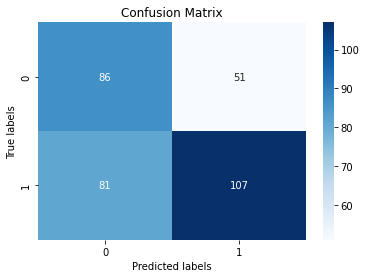

In [18]:
%%time

# train a model for each of the mri types and then ensemble predictions

all_test_preds = []
all_val_preds = []
total_train_time=[]

for mt in ['flair','t1w', 't1wce', 't2w']:
    train_df, val_df = get_train_val_dataframe(mt)
    test_df = get_test_dataframe(mt)
    
    train_g, val_g, test_g = get_data_generators(train_df, val_df, test_df)
    best_model,history_model,s =  train_model(mt, train_g, val_g, epochs=20)
    total_train_time.append(s)
    
    np.save(mt+'_history_model.npy',history_model.history)
    
    
    result_val = best_model.evaluate(val_g, steps=len(val_g))
    print(f"val loss, val acc, val AUC: {result_val}")
    
    ## saving validation metrics
    np.save(mt+'_result_val.npy',result_val)
    
    val_pred = best_model.predict(val_g, steps=len(val_g))
    val_mean_pred = val_pred.mean()
    val_df['pred_y'] = val_pred
    
    ## draw confusion matrix of each mri modality and save as png file
    drawConfusionMatrix2(val_df,mt)
    
    val_pred_agg = val_df.groupby('patient_ids').apply(
        lambda x: x['pred_y'].max()
        if (x['pred_y'].max() - val_mean_pred) > (val_mean_pred - x['pred_y'].min()) 
        else x['pred_y'].min())
    all_val_preds.append(val_pred_agg.values)
    
    test_pred = best_model.predict(test_g, steps=len(test_g))
    test_df['pred_y'] = test_pred
    
    """
         aggregate the predictions on all image for each person ,
         take the most confident prediction out of all image predictions
    """
    mean_pred = test_pred.mean()
    test_pred_agg = test_df.groupby('patient_ids').apply(
        lambda x: x['pred_y'].max()
        if (x['pred_y'].max() - mean_pred) > (mean_pred - x['pred_y'].min()) 
        else x['pred_y'].min())
    all_test_preds.append(test_pred_agg.values)

## Printing total training time

In [19]:
print("Total Training time ",sum(total_train_time))

Total Training time  8190.280542612076


## Draw confusion matrix for architecture

In [20]:
def drawConfusionMatrix3(val_df,mt):
    print(len(val_df))
    cf_matrix = confusion_matrix(val_df['labels'], val_df['pred_y'])
    ax=plt.subplot()
    sns.heatmap(cf_matrix, annot=True,fmt='g',ax=ax,cmap="Blues");
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');
    plt.savefig(mt+"_confusion_matrix.png")

In [21]:
def buildConfusionMatrixForArchitecture(all_val_preds):
    all_val_preds=np.array(all_val_preds)
    final_val_pred=all_val_preds.mean(0)
    train_df, val_df = get_train_val_dataframe('flair')
    new_val_df=val_df[['patient_ids','labels']].drop_duplicates()
    val_pred_label=['1' if i>0.5 else '0' for i in final_val_pred]
    new_val_df['pred_y']=val_pred_label
    drawConfusionMatrix3(new_val_df,'InceptionV3')

57


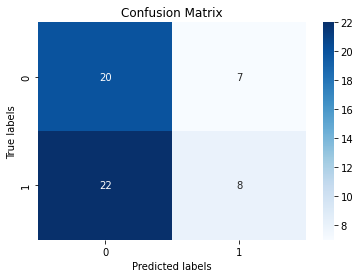

In [22]:
buildConfusionMatrixForArchitecture(all_val_preds)

## Method to plot loss graph

In [23]:
def plotLossGraph(history_model,mt):
    fig, ax1 = plt.subplots(dpi=100)
    fig.set_size_inches(6.5, 4.5)
    plt.plot(history_model['loss'], 'r', label = 'training loss', )
    plt.plot(history_model['val_loss'], 'g', label = 'validation loss' )
    plt.legend(loc='lower left')
    plt.xlabel('Training epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.savefig(mt+'_train_val_loss'+'.png')
    plt.show()

## Plotting loss graph for each modality(model)

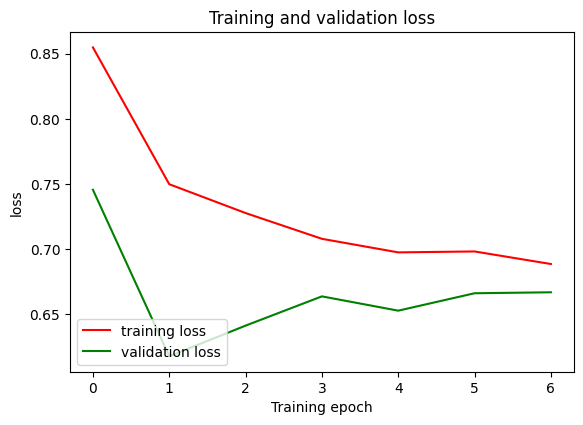

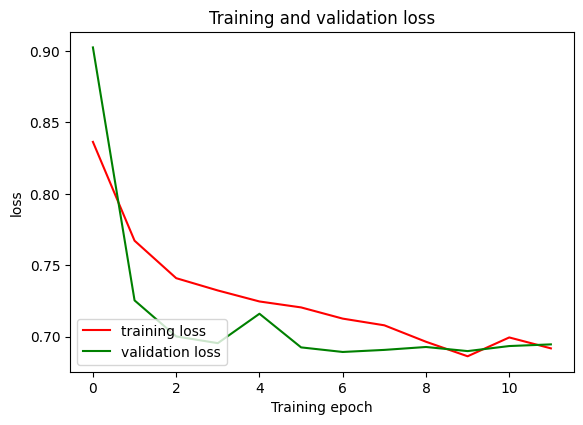

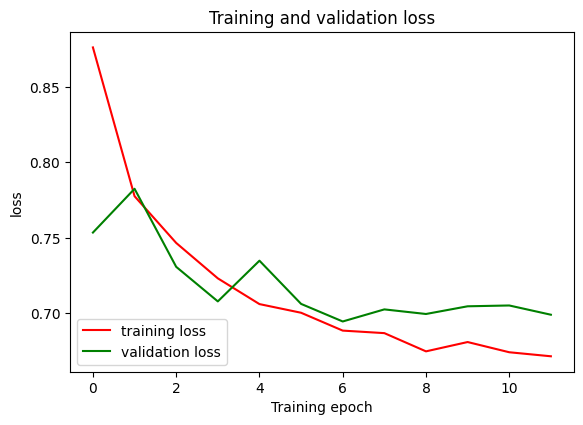

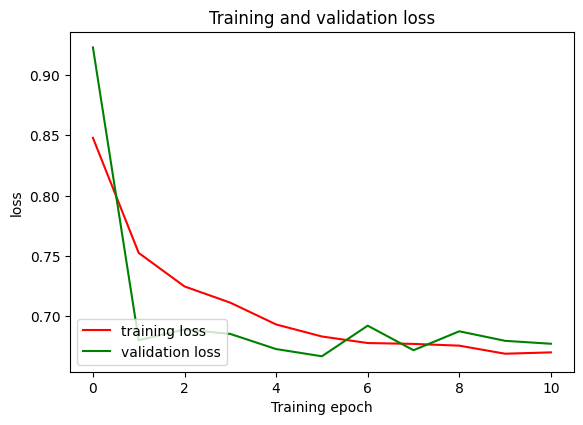

In [24]:
for mt in ['flair','t1w', 't1wce', 't2w']:
    history1=np.load(mt+'_history_model.npy',allow_pickle=True).item()
    plotLossGraph(history1,mt)

## Preparing the prediction for submission to Kaggle

In [25]:
all_test_preds = np.array(all_test_preds)

In [26]:
submission = pd.read_csv(root_dir+'sample_submission.csv')
submission['MGMT_value'] = all_test_preds.mean(0)
submission.to_csv("submission.csv", index=False)

In [27]:
submission

BraTS21ID  MGMT_value
0           1    0.700232
1          13    0.630042
2          15    0.606975
3          27    0.540218
4          37    0.518458
..        ...         ...
82        826    0.420048
83        829    0.431709
84        833    0.410996
85        997    0.517501
86       1006    0.487480

[87 rows x 2 columns]